<a href="https://colab.research.google.com/github/SergeyShchus/Satellite-Imagery-Analysis/blob/master/jupyter-notebooks/detecting-changes/Krimea_Detecting_Changes_in_Sentinel_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, gamma, f, chi2
import IPython.display as disp
%matplotlib inline

In [6]:
import ee
 
# Trigger the authentication flow.
ee.Authenticate()
 
# Initialize the library.
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=Mr-yg1EQsSDTl3B4uizJIeNEOrDUgGGLi9r_YFKWooo&tc=rKPMTzsYhFS9j44dFxYhHmJ8LhB9j5KC2aO7t0s4A0k&cc=3AVorjgJPak5KSXhsupidHAtcE3TjagMqScJUF8ogmg

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AVHEtk4Gt-LcoDTeNubNUfOV6uzMDY0CBbWTJquvvIs25fgTEZfCQxltnps

Successfully saved authorization token.


In [2]:
# Import the Folium library.
import folium

# Define a method for displaying Earth Engine image tiles to folium map.
def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
    tiles = map_id_dict['tile_fetcher'].url_format,
    attr = 'Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    name = name,
    overlay = True,
    control = True
  ).add_to(self)

# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

In [11]:
geoJSON = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "coordinates": [
          [
            [
              34.53761118389346,
              45.91241661555611
            ],
            [
              34.53761118389346,
              45.87333450920727
            ],
            [
              34.617740906908665,
              45.87333450920727
            ],
            [
              34.617740906908665,
              45.91241661555611
            ],
            [
              34.53761118389346,
              45.91241661555611
            ]
          ]
        ],
        "type": "Polygon"
      }
    }
  ]
}



In [12]:
coords = geoJSON['features'][0]['geometry']['coordinates']
aoi = ee.Geometry.Polygon(coords)

In [13]:
ffa_db = ee.Image(ee.ImageCollection('COPERNICUS/S1_GRD') 
                       .filterBounds(aoi) 
                       .filterDate(ee.Date('2022-08-01'), ee.Date('2022-08-31')) 
                       .first() 
                       .clip(aoi))
ffa_fl = ee.Image(ee.ImageCollection('COPERNICUS/S1_GRD_FLOAT') 
                       .filterBounds(aoi) 
                       .filterDate(ee.Date('2022-08-01'), ee.Date('2022-08-31')) 
                       .first() 
                       .clip(aoi))

In [14]:
ffa_db.bandNames().getInfo()

['VV', 'VH', 'angle']

In [15]:
url = ffa_db.select('VV').getThumbURL({'min': -20, 'max': 0})
disp.Image(url=url, width=800)

In [16]:
location = aoi.centroid().coordinates().getInfo()[::-1]

# Make an RGB color composite image (VV,VH,VV/VH).
rgb = ee.Image.rgb(ffa_db.select('VV'),
                   ffa_db.select('VH'),
                   ffa_db.select('VV').divide(ffa_db.select('VH')))

# Create the map object.
m = folium.Map(location=location, zoom_start=12)

# Add the S1 rgb composite to the map object.
m.add_ee_layer(rgb, {'min': [-20, -20, 0], 'max': [0, 0, 2]}, 'FFA')

# Add a layer control panel to the map.
m.add_child(folium.LayerControl())

# Display the map.
display(m)

In [30]:
geoJSON = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "coordinates": [
          [
            [
              34.60736529118435,
              45.88468456835301
            ],
            [
              34.60788439735981,
              45.882211508752306
            ],
            [
              34.61009059860302,
              45.882335728983975
            ],
            [
              34.61148569644894,
              45.8850233350677
            ],
            [
              34.60736529118435,
              45.88468456835301
            ]
          ]
        ],
        "type": "Polygon"
      }
    }
  ]
}
coords = geoJSON['features'][0]['geometry']['coordinates']
aoi_sub = ee.Geometry.Polygon(coords)

In [31]:
hist = ffa_fl.select('VV').reduceRegion(
    ee.Reducer.fixedHistogram(0, 0.5, 500),aoi_sub).get('VV').getInfo()
mean = ffa_fl.select('VV').reduceRegion(
    ee.Reducer.mean(), aoi_sub).get('VV').getInfo()
variance = ffa_fl.select('VV').reduceRegion(
    ee.Reducer.variance(), aoi_sub).get('VV').getInfo()

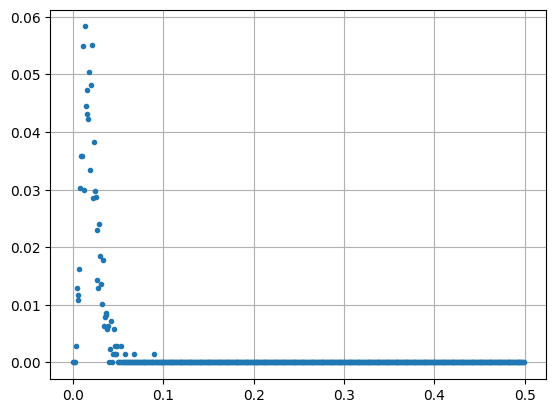

In [32]:
a = np.array(hist)
x = a[:, 0]                 # array of bucket edge positions
y = a[:, 1]/np.sum(a[:, 1]) # normalized array of bucket contents
plt.grid()
plt.plot(x, y, '.')
plt.show()

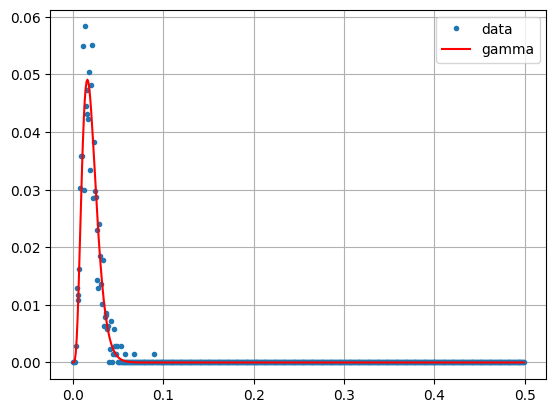

In [33]:
alpha = 5
beta = mean/alpha
plt.grid()
plt.plot(x, y, '.', label='data')
plt.plot(x, gamma.pdf(x, alpha, 0, beta)/1000, '-r', label='gamma')
plt.legend()
plt.show()

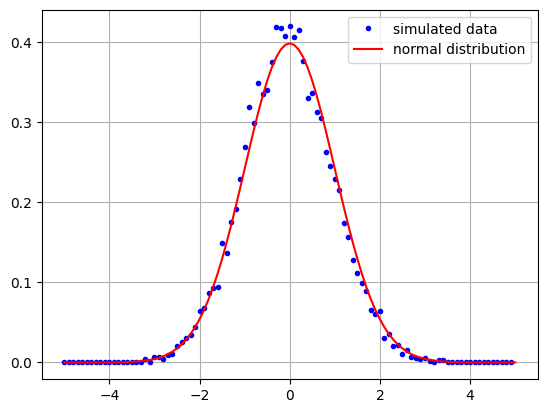

In [34]:
def X(n):
    return np.sum(np.cos(4*np.pi*(np.random.rand(n)-0.5)))/np.sqrt(n/2)

n= 10000
Xs = [X(n) for i in range(10000)]
y, x = np.histogram(Xs, 100, range=[-5,5])
plt.plot(x[:-1], y/1000, 'b.', label='simulated data')
plt.plot(x, norm.pdf(x), '-r', label='normal distribution')
plt.grid()
plt.legend()
plt.show()

----------------------------

З однаковими кутами падіння!

In [35]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, gamma, f, chi2
import IPython.display as disp
%matplotlib inline

# Import the Folium library.
import folium

# Define a method for displaying Earth Engine image tiles to folium map.
def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
    tiles = map_id_dict['tile_fetcher'].url_format,
    attr = 'Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    name = name,
    overlay = True,
    control = True
  ).add_to(self)

# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

In [36]:
geoJSON = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "coordinates": [
          [
            [
              34.53761118389346,
              45.91241661555611
            ],
            [
              34.53761118389346,
              45.87333450920727
            ],
            [
              34.617740906908665,
              45.87333450920727
            ],
            [
              34.617740906908665,
              45.91241661555611
            ],
            [
              34.53761118389346,
              45.91241661555611
            ]
          ]
        ],
        "type": "Polygon"
      }
    }
  ]
}
coords = geoJSON['features'][0]['geometry']['coordinates']
aoi = ee.Geometry.Polygon(coords)
geoJSON = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "coordinates": [
          [
            [
              34.60736529118435,
              45.88468456835301
            ],
            [
              34.60788439735981,
              45.882211508752306
            ],
            [
              34.61009059860302,
              45.882335728983975
            ],
            [
              34.61148569644894,
              45.8850233350677
            ],
            [
              34.60736529118435,
              45.88468456835301
            ]
          ]
        ],
        "type": "Polygon"
      }
    }
  ]
}
coords = geoJSON['features'][0]['geometry']['coordinates']
aoi_sub = ee.Geometry.Polygon(coords)

In [79]:
im_coll = (ee.ImageCollection('COPERNICUS/S1_GRD_FLOAT')
                .filterBounds(aoi)
                .filterDate(ee.Date('2022-07-01'),ee.Date('2022-10-30'))
                .filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING'))
                .filter(ee.Filter.eq('relativeOrbitNumber_start', 167))
                .sort('system:time_start'))

In [80]:
import time
acq_times = im_coll.aggregate_array('system:time_start').getInfo()
[time.strftime('%x', time.gmtime(acq_time/1000)) for acq_time in acq_times]

['07/07/22',
 '07/19/22',
 '07/31/22',
 '08/12/22',
 '09/05/22',
 '09/17/22',
 '09/29/22',
 '10/11/22',
 '10/23/22']

In [81]:
im_list = im_coll.toList(im_coll.size())
im1 = ee.Image(im_list.get(0)).select('VV').clip(aoi_sub)
im2 = ee.Image(im_list.get(8)).select('VV').clip(aoi_sub)

In [82]:
ratio = im1.divide(im2)
url = ratio.getThumbURL({'min': 0, 'max': 10})
disp.Image(url=url, width=800)

In [83]:
hist = ratio.reduceRegion(ee.Reducer.fixedHistogram(0, 5, 500), aoi_sub).get('VV').getInfo()
mean = ratio.reduceRegion(ee.Reducer.mean(), aoi_sub).get('VV').getInfo()
variance = ratio.reduceRegion(ee.Reducer.variance(), aoi_sub).get('VV').getInfo()

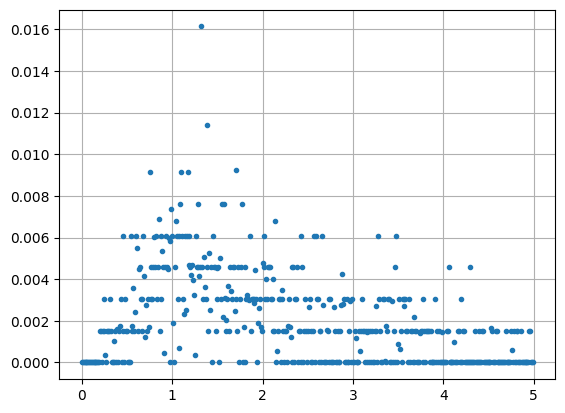

In [84]:
a = np.array(hist)
x = a[:, 0]
y = a[:, 1] / np.sum(a[:, 1])
plt.grid()
plt.plot(x, y, '.')
plt.show()

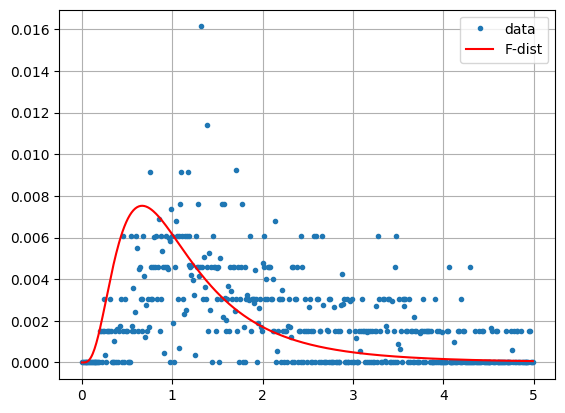

In [85]:
m = 5
plt.grid()
plt.plot(x, y, '.', label='data')
plt.plot(x, f.pdf(x, 2*m, 2*m) / 100, '-r', label='F-dist')
plt.legend()
plt.show()

In [86]:
print(mean, m/(m-1))
print(variance, m*(2*m-1)/(m-1)**2/(m-2))

2.1598450441481374 1.25
2.9684499874471504 0.9375


In [87]:
im1 = ee.Image(im_list.get(0)).select('VV').clip(aoi)
im2 = ee.Image(im_list.get(1)).select('VV').clip(aoi)
ratio = im1.divide(im2)

location = aoi.centroid().coordinates().getInfo()[::-1]
mp = folium.Map(location=location, zoom_start=12)
mp.add_ee_layer(ratio,
                {'min': 0, 'max': 20, 'palette': ['black', 'white']}, 'Ratio')
mp.add_child(folium.LayerControl())

display(mp)

In [88]:
# Decision threshold alpha/2:
dt = f.ppf(0.0005, 2*m, 2*m)

# LRT statistics.
q1 = im1.divide(im2)
q2 = im2.divide(im1)

# Change map with 0 = no change, 1 = decrease, 2 = increase in intensity.
c_map = im1.multiply(0).where(q2.lt(dt), 1)
c_map = c_map.where(q1.lt(dt), 2)

# Mask no-change pixels.
c_map = c_map.updateMask(c_map.gt(0))

# Display map with red for increase and blue for decrease in intensity.
location = aoi.centroid().coordinates().getInfo()[::-1]
mp = folium.Map(
    location=location, tiles='Stamen Toner',
    zoom_start=13)
folium.TileLayer('OpenStreetMap').add_to(mp)
mp.add_ee_layer(ratio,
                {'min': 0, 'max': 20, 'palette': ['black', 'white']}, 'Ratio')
mp.add_ee_layer(c_map,
                {'min': 0, 'max': 2, 'palette': ['black', 'blue', 'red']},
                'Change Map')
mp.add_child(folium.LayerControl())

display(mp)